#                        Projet sur les cantines

### 1 - Consignes et livrables

Travail de groupe de 3 personnes. 

Pour l'évaluation CC, chaque groupe doit livrer à la fin des sessions :

    - un rapport synthétisant l'analyse faite et les conculusions obtenues
    
    - un notebook nettoyé et commenté

### 2 - Brief du projet 

   
La cuisine centrale de Nantes Métropole produit par jour entre 15 000 et 16 000 repas qui sont livrés dans 87 établissements. Les familles ont la
possibilité d’inscrire ou non les enfants le jour même. 

Ce système entraine une grande variabilité dans la fréquentation. Celle-ci est eCectivement
impactée  par  le  contexte  sanitaire,  la  composition  des  menus,  le  jour  de  la  semaine,  la  période  de  l’année...  

Cette  variabilité  contraint  les
cantines, très en amont (S-3), à estimer systématiquement le nombre de convives. Ces estimations servent à évaluer les quantités à commander
aux fournisseurs. Un constat : le gaspillage alimentaire sur l’ensemble de la métropole est passée de 5% en moyenne entre 2011 et 2016 à 8% sur
2017-2019.

En tant que responsable des finances de la cuisine, vous voulez réduire ce gaspillage de surproduction pour faire des économies.  Un repas coûte en matière première 3 euros. 

Vous allez donc analyser les données afin de trouver les facteurs qui influencent la fréquentation des cantines et essayer de proposer une solution pour réduire le gaspillage (un modèle statistique par exemple).

### 3 - Organisation du service 

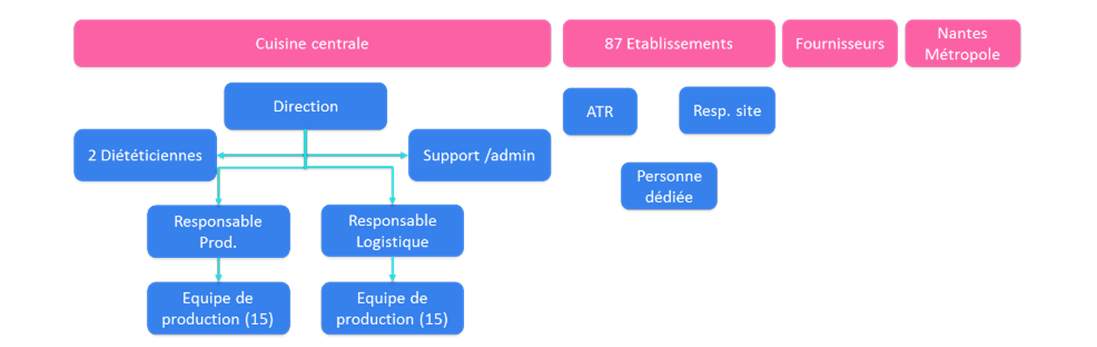

### 4 - Processus actuel

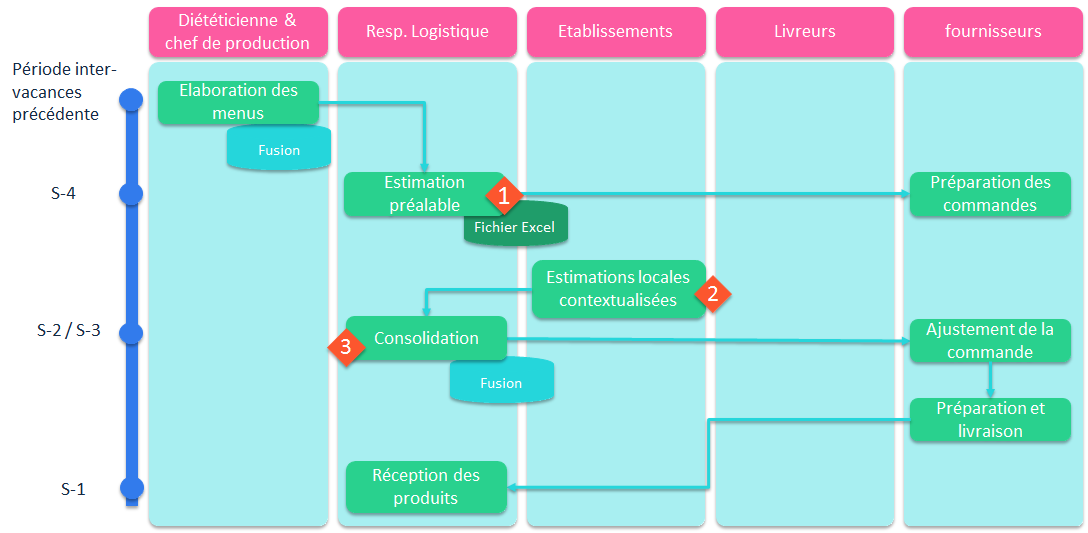

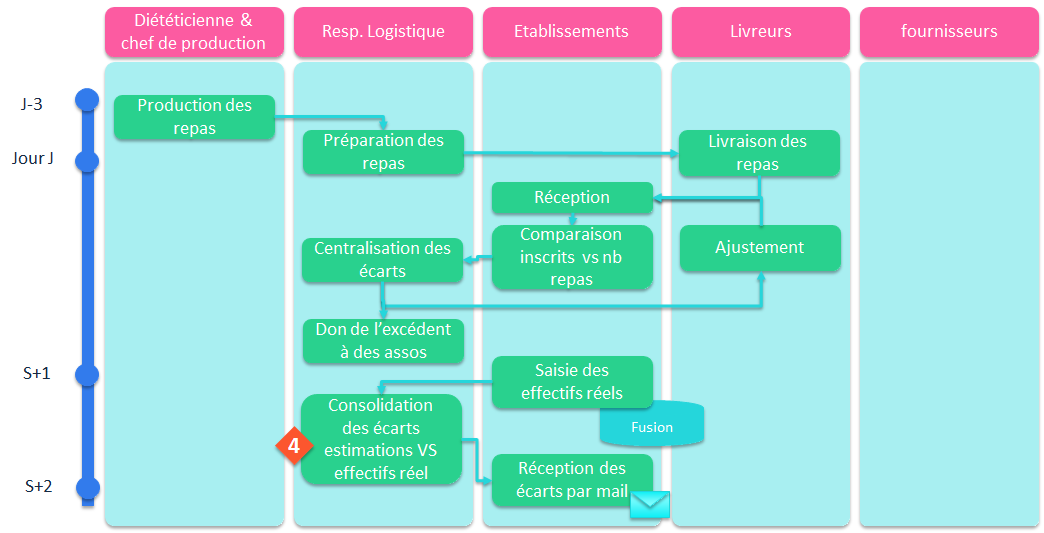

Les entêtes de colonnes indiquent les acteurs mobilisés ; 

l’axe vertical à gauche du graphique indique la position de chaque étape par rapport au jour de consommation (S = semaine et J = jour) ; 

les blocs verts indiquent les étapes du processus de planification, réalisation et suivi de la production  ; les blocs bleus indiquent les outils numériques utilisés ; 

les losanges orange indiquent les étapes auxquelles les outils de modélisation peuvent être utilisés.

Les quatre losanges mis en évidence en orange sur le schéma représentent les étapes auxquelles des interactions peuvent être développées entre l’outil de modélisation statistique et le processus de préparation des repas de la cuisine centrale à Nantes. 

Une fois les menus pour une période intervacances validés par la commission de restauration, ils sont transmis au responsable logistique. Celui-ci réalise des estimations globales de la fréquentation attendue et passe ses commandes auprès des fournisseurs locaux environ un mois à l’avance. L'objectif de votre travail est de fiabiliser cette étape (losange 1) à l'aide d'un modèle statistique.



### 5 - Votre mission 


Analyser le jeu de données afin de repérer des variables pertinentes pour la mission. 

Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. 

Nettoyer le jeu de données : identifier les colonnes inutiles (variables non pertinentes) et vérifier si toutes les lignes sont exploitables 

Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement. Variez les graphiques (boxplots, histogrammes, diagrammes circulaires, nuages de points…) pour illustrer au mieux votre propos.

Confirmer ou infirmer les hypothèses à l’aide d’une analyse multivariée (plusieurs variables). Le plus important sera de déterminer les facteurs qui jouent le plus sur la fréquentation.

Identifier des arguments justifiant la faisabilité d'une fiabilisation des commandes en utilisant un modèle statistique. Est-ce possible d'après vous ?






### 6 - Recommandation

Le nombre de repas consommés par jour dépend fortement de l’effectif global (somme des effectifs de 87 établissements), or cet effectif a évolué sur les 10 ans d’historique. 

Pour les analyses, je vous recommande de créer dans votre dataframe une colonne correspondant à la fréquentation, c’est-à-dire au nombre de repas consommés par jour divisé par l’effectif global. En analysant la fréquentation, on ne tient pas compte de l’effet d’échelle de l’effectif.


# Analyse

## 1. Préparation environement

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import datetime as dt
import pandas as pd
import numpy as np
import scipy
from scipy.stats import chi2_contingency as chi2_contingency
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams["figure.figsize"] = (12, 6)
sns.set()

pd.set_option("display.max_columns", None)

from pandas.api.types import CategoricalDtype


In [2]:
# read data sets
frequentation = pd.read_csv("frequentation.csv", index_col="date", parse_dates=True)
menus = pd.read_csv("menus.csv", index_col="date", parse_dates=True)

In [3]:
frequentation.head(3)

,Unnamed: 0,annee_scolaire,jour,semaine,mois,greves,ferie,veille_ferie,retour_ferie,vacances,retour_vacances,veille_vacances,fete_musulmane,ramadan,fete_chretienne,fete_juive,inc_grippe,inc_gastro,inc_varicelle,prevision,reel,effectif
date,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,0,2010-2011,Lundi,1,Janvier,0,0,0,0,0,1,0,0,0,0,0,10505,6554,551,12289,11129,17373
2011-01-04,1,2010-2011,Mardi,1,Janvier,0,0,0,0,0,0,0,0,0,0,0,10505,6554,551,12558,11808,17373
2011-01-06,2,2010-2011,Jeudi,1,Janvier,0,0,0,0,0,0,0,0,0,1,0,10505,6554,551,12753,11741,17373


In [4]:
# initialize function in case of affection not on purpose
def frequentation_init():
    frequentation = pd.read_csv("frequentation.csv", index_col="date", parse_dates=True)
    return frequentation

def menu_init():
    menus = pd.read_csv("menus.csv", index_col="date", parse_dates=True)
    return menus

In [5]:
# to make the weekday columns in order to literal, not to alphabet
weekday_order = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi"]
weekday_dtype = CategoricalDtype(categories=weekday_order, ordered=True)
frequentation["jour"] = frequentation["jour"].astype(weekday_dtype)

#  and month
month_order = ['Janvier', 'Fevrier', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Septembre', 'Octobre', 'Novembre', 'Decembre']
month_dtype = CategoricalDtype(categories=month_order, ordered=True)
frequentation["mois"] = frequentation["mois"].astype(month_dtype)

In [6]:
frequentation.effectif.unique()

array([17373, 17652, 17660, 17955, 18123, 17842, 18243, 18633, 18497,
       19066, 19639, 19958, 20344, 20685], dtype=int64)

In [7]:
frequentation.jour.unique()

['Lundi', 'Mardi', 'Jeudi', 'Vendredi', 'Mercredi']
Categories (5, object): ['Lundi' < 'Mardi' < 'Mercredi' < 'Jeudi' < 'Vendredi']

In [8]:
frequentation.mois.unique()

['Janvier', 'Fevrier', 'Mars', 'Avril', 'Mai', ..., 'Juillet', 'Septembre', 'Octobre', 'Novembre', 'Decembre']
Length: 11
Categories (11, object): ['Janvier' < 'Fevrier' < 'Mars' < 'Avril' ... 'Septembre' < 'Octobre' < 'Novembre' < 'Decembre']

## 2. Pré-traitement

In [9]:
freq = frequentation.copy()
menus_temp = menus.copy()

In [10]:
def rm_unnamed(df):
    df.drop(columns="Unnamed: 0", inplace=True)
    return df
rm_unnamed(freq)
rm_unnamed(menus_temp)

,menu,porc,viande,poisson,bio,noel,frites,an_chinois
date,,,,,,,,
2011-01-03,"['Pamplemousse', 'Hachis Parmentier', 'Salade ...",0,1,0,0,0,0,0
2011-01-04,"['Crêpe au fromage', 'emincé de volaille à la ...",0,1,0,0,0,0,0
2011-01-06,"['thon', 'Mâche au thon', 'Croziflette', 'des ...",1,1,0,1,0,0,0
2011-01-07,"['Choux blancs mimolette', 'milanette en des',...",0,0,1,0,0,0,0
2011-01-10,"['Endives / demi-\x9cuf', 'paella de la mer', ...",0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
2019-12-09,"['Demi-pamplemousse', 'Omelette bio', 'Ratatou...",0,0,0,1,0,0,0
2019-12-10,"['Choux rouges bio au gruyère', 'Sauté de porc...",1,1,0,1,0,0,0
2019-12-13,"['Betteraves', 'Poisson', 'Pommes rissolées', ...",0,0,1,1,0,0,0


In [11]:
freq.groupby(["annee_scolaire","effectif"]).count()

jour  semaine  mois  greves  ferie  veille_ferie  \
annee_scolaire effectif                                                     
2010-2011      17373       87       87    87      87     87            87   
               17652        4        4     4       4      4             4   
2011-2012      17660       53       53    53      53     53            53   
               17955       86       86    86      86     86            86   
2012-2013      17842       86       86    86      86     86            86   
               18123       55       55    55      55     55            55   
2013-2014      18243      141      141   141     141    141           141   
2014-2015      18497       27       27    27      27     27            27   
               18633       82       82    82      82     82            82   
2015-2016      19066      125      125   125     125    125           125   
2016-2017      19639      131      131   131     131    131           131   
2017-2018      19958      131      131   131     131    131           131   
2018-2019      20344      131      131   131     131    131           131   
2019-2020      20685       49       49    49      49     49            49   

                         retour_ferie  vacances  retour_vacances  \
annee_scolaire effectif                                            
2010-2011      17373               87        87               87   
               17652                4         4                4   
2011-2012      17660               53        53               53   
               17955               86        86               86   
2012-2013      17842               86        86               86   
               18123               55        55               55   
2013-2014      18243              141       141              141   
2014-2015      18497               27        27               27   
               18633               82        82               82   
2015-2016      19066              125       125              125   
2016-2017      19639              131       131              131   
2017-2018      19958              131       131              131   
2018-2019      20344              131       131              131   
2019-2020      20685               49        49               49   

                         veille_vacances  fete_musulmane  ramadan  \
annee_scolaire effectif                                             
2010-2011      17373                  87              87       87   
               17652                   4               4        4   
2011-2012      17660                  53              53       53   
               17955                  86              86       86   
2012-2013      17842                  86              86       86   
               18123                  55              55       55   
2013-2014      18243                 141             141      141   
2014-2015      18497                  27              27       27   
               18633                  82              82       82   
2015-2016      19066                 125             125      125   
2016-2017      19639                 131             131      131   
2017-2018      19958                 131             131      131   
2018-2019      20344                 131             131      131   
2019-2020      20685                  49              49       49   

                         fete_chretienne  fete_juive  inc_grippe  inc_gastro  \
annee_scolaire effectif                                                        
2010-2011      17373                  87          87          87          87   
               17652                   4           4           4           4   
2011-2012      17660                  53          53          53          53   
               17955                  86          86          86          86   
2012-2013      17842                  86          86          86          86   
               18123                  

In [12]:
freq = freq.replace(17652,17373)
freq = freq.replace(17660,17955)
freq = freq.replace(18123,17842)
freq = freq.replace(18497,18633)

In [13]:
freq.groupby(["annee_scolaire","effectif"]).count()

,,jour,semaine,mois,greves,ferie,veille_ferie,retour_ferie,vacances,retour_vacances,veille_vacances,fete_musulmane,ramadan,fete_chretienne,fete_juive,inc_grippe,inc_gastro,inc_varicelle,prevision,reel
annee_scolaire,effectif,,,,,,,,,,,,,,,,,,,
2010-2011,17373,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91
2011-2012,17955,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139
2012-2013,17842,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141
2013-2014,18243,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141
2014-2015,18633,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109
2015-2016,19066,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125
2016-2017,19639,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131
2017-2018,19958,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131
2018-2019,20344,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131


In [14]:
df_jours = pd.get_dummies(freq.jour)
df_mois = pd.get_dummies(freq.mois)

In [15]:
df_jourmois = pd.merge(df_jours, df_mois, on="date")
freq_2 = pd.merge(freq, df_jourmois, on="date")
freq_2.drop(columns=["jour","mois"], inplace=True)
freq_2

,annee_scolaire,semaine,greves,ferie,veille_ferie,retour_ferie,vacances,retour_vacances,veille_vacances,fete_musulmane,ramadan,fete_chretienne,fete_juive,inc_grippe,inc_gastro,inc_varicelle,prevision,reel,effectif,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Septembre,Octobre,Novembre,Decembre
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,2010-2011,1,0,0,0,0,0,1,0,0,0,0,0,10505,6554,551,12289,11129,17373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2011-01-04,2010-2011,1,0,0,0,0,0,0,0,0,0,0,0,10505,6554,551,12558,11808,17373,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2011-01-06,2010-2011,1,0,0,0,0,0,0,0,0,0,1,0,10505,6554,551,12753,11741,17373,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2011-01-07,2010-2011,1,0,0,0,0,0,0,0,0,0,1,0,10505,6554,551,12812,12322,17373,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2011-01-10,2010-2011,2,0,0,0,0,0,0,0,0,0,0,0,7200,6453,493,12309,11302,17373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-09,2019-2020,50,0,0,0,0,0,0,0,0,0,0,0,1274,9715,99,15991,10898,20685,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2019-12-10,2019-2020,50,0,0,0,0,0,0,0,0,0,0,0,1274,9715,99,15885,6442,20685,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2019-12-13,2019-2020,50,1,0,0,0,0,0,0,0,0,0,0,1274,9715,99,17436,9168,20685,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [16]:
data = pd.merge(freq_2, menus_temp, on="date")
data

,annee_scolaire,semaine,greves,ferie,veille_ferie,retour_ferie,vacances,retour_vacances,veille_vacances,fete_musulmane,ramadan,fete_chretienne,fete_juive,inc_grippe,inc_gastro,inc_varicelle,prevision,reel,effectif,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Septembre,Octobre,Novembre,Decembre,menu,porc,viande,poisson,bio,noel,frites,an_chinois
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,2010-2011,1,0,0,0,0,0,1,0,0,0,0,0,10505,6554,551,12289,11129,17373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"['Pamplemousse', 'Hachis Parmentier', 'Salade ...",0,1,0,0,0,0,0
2011-01-04,2010-2011,1,0,0,0,0,0,0,0,0,0,0,0,10505,6554,551,12558,11808,17373,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"['Crêpe au fromage', 'emincé de volaille à la ...",0,1,0,0,0,0,0
2011-01-06,2010-2011,1,0,0,0,0,0,0,0,0,0,1,0,10505,6554,551,12753,11741,17373,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,"['thon', 'Mâche au thon', 'Croziflette', 'des ...",1,1,0,1,0,0,0
2011-01-07,2010-2011,1,0,0,0,0,0,0,0,0,0,1,0,10505,6554,551,12812,12322,17373,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,"['Choux blancs mimolette', 'milanette en des',...",0,0,1,0,0,0,0
2011-01-10,2010-2011,2,0,0,0,0,0,0,0,0,0,0,0,7200,6453,493,12309,11302,17373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"['Endives / demi-\x9cuf', 'paella de la mer', ...",0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-09,2019-2020,50,0,0,0,0,0,0,0,0,0,0,0,1274,9715,99,15991,10898,20685,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"['Demi-pamplemousse', 'Omelette bio', 'Ratatou...",0,0,0,1,0,0,0
2019-12-10,2019-2020,50,0,0,0,0,0,0,0,0,0,0,0,1274,9715,99,15885,6442,20685,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"['Choux rouges bio au gruyère', 'Sauté de porc...",1,1,0,1,0,0,0
2019-12-13,2019-2020,50,1,0,0,0,0,0,0,0,0,0,0,1274,9715,99,17436,9168,20685,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,"['Betteraves', 'Poisson', 'Pommes rissolées', ...",0,0,1,1,0,0,0


In [17]:
# make new columns ratio and target of prediction(reel +200 dichies)

data["ratio"] = data["reel"]/data["effectif"]
data["target"] = data["reel"]+200

# cast school year
# frequentation["annee_scolaire"] = frequentation["annee_scolaire"].astype("category")

In [18]:
data

,annee_scolaire,semaine,greves,ferie,veille_ferie,retour_ferie,vacances,retour_vacances,veille_vacances,fete_musulmane,ramadan,fete_chretienne,fete_juive,inc_grippe,inc_gastro,inc_varicelle,prevision,reel,effectif,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Septembre,Octobre,Novembre,Decembre,menu,porc,viande,poisson,bio,noel,frites,an_chinois,ratio,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,2010-2011,1,0,0,0,0,0,1,0,0,0,0,0,10505,6554,551,12289,11129,17373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"['Pamplemousse', 'Hachis Parmentier', 'Salade ...",0,1,0,0,0,0,0,0.640592,11329
2011-01-04,2010-2011,1,0,0,0,0,0,0,0,0,0,0,0,10505,6554,551,12558,11808,17373,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"['Crêpe au fromage', 'emincé de volaille à la ...",0,1,0,0,0,0,0,0.679675,12008
2011-01-06,2010-2011,1,0,0,0,0,0,0,0,0,0,1,0,10505,6554,551,12753,11741,17373,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,"['thon', 'Mâche au thon', 'Croziflette', 'des ...",1,1,0,1,0,0,0,0.675819,11941
2011-01-07,2010-2011,1,0,0,0,0,0,0,0,0,0,1,0,10505,6554,551,12812,12322,17373,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,"['Choux blancs mimolette', 'milanette en des',...",0,0,1,0,0,0,0,0.709261,12522
2011-01-10,2010-2011,2,0,0,0,0,0,0,0,0,0,0,0,7200,6453,493,12309,11302,17373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"['Endives / demi-\x9cuf', 'paella de la mer', ...",0,0,1,0,0,0,0,0.650550,11502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-09,2019-2020,50,0,0,0,0,0,0,0,0,0,0,0,1274,9715,99,15991,10898,20685,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"['Demi-pamplemousse', 'Omelette bio', 'Ratatou...",0,0,0,1,0,0,0,0.526855,11098
2019-12-10,2019-2020,50,0,0,0,0,0,0,0,0,0,0,0,1274,9715,99,15885,6442,20685,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"['Choux rouges bio au gruyère', 'Sauté de porc...",1,1,0,1,0,0,0,0.311433,6642
2019-12-13,2019-2020,50,1,0,0,0,0,0,0,0,0,0,0,1274,9715,99,17436,9168,20685,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,"['Betteraves', 'Poisson', 'Pommes rissolées', ...",0,0,1,1,0,0,0,0.443220,9368


In [19]:
# anomaly positive cantine data for no schooldays
rm_id = data[data["vacances"]==1].index
rm_id

DatetimeIndex(['2011-05-02', '2011-05-03', '2011-05-05', '2011-05-06',
               '2011-05-09', '2012-04-23', '2015-04-27', '2016-02-22',
               '2016-02-23', '2016-02-25', '2016-02-26', '2016-04-18',
               '2016-04-19', '2016-04-21', '2016-04-22', '2016-04-25',
               '2016-04-26', '2016-04-29', '2016-05-02', '2017-02-27',
               '2017-02-28', '2017-03-02', '2017-03-03', '2017-03-06',
               '2017-04-24', '2017-04-25', '2017-04-27', '2017-04-28',
               '2017-05-02', '2017-05-04', '2017-05-05', '2018-04-23',
               '2018-04-24'],
              dtype='datetime64[ns]', name='date', freq=None)

In [20]:
rm_id2 = data[data["greves"]==1].index
rm_id2

DatetimeIndex(['2011-03-28', '2011-05-16', '2011-05-31', '2011-09-27',
               '2011-11-10', '2011-12-13', '2011-12-15', '2012-01-31',
               '2012-02-02', '2012-03-27',
               ...
               '2019-06-28', '2019-07-02', '2019-09-05', '2019-09-12',
               '2019-10-01', '2019-11-12', '2019-12-03', '2019-12-13',
               '2019-12-16', '2019-12-19'],
              dtype='datetime64[ns]', name='date', length=105, freq=None)

In [21]:
# anomaly menu data like [menu dépannage], []
rm_id3 = menus[menus["Unnamed: 0"].isin([142,160,290,326,344,375,404,416,815,882,887,1002])].index
rm_id3

DatetimeIndex(['2011-12-15', '2012-01-31', '2013-01-15', '2013-04-03',
               '2013-05-22', '2013-09-10', '2013-11-14', '2013-12-05',
               '2017-02-07', '2017-09-12', '2017-09-21', '2018-06-28'],
              dtype='datetime64[ns]', name='date', freq=None)

In [22]:
menus[menus["Unnamed: 0"].isin([142,160,290,326,344,375,404,416,815,882,887,1002])]

,Unnamed: 0,menu,porc,viande,poisson,bio,noel,frites,an_chinois
date,,,,,,,,,
2011-12-15,142,['repas greves'],0,0,0,0,0,0,0
2012-01-31,160,"['menu de depannage', 'en stock']",0,0,0,0,0,0,0
2013-01-15,290,['Frites'],0,0,0,0,0,1,0
2013-04-03,326,[],0,0,0,0,0,0,0
2013-05-22,344,[],0,0,0,0,0,0,0
2013-09-10,375,"['repas depannage', 'greves']",0,0,0,0,0,0,0
2013-11-14,404,['menu greve'],0,0,0,0,0,0,0
2013-12-05,416,['repas grève'],0,0,0,0,0,0,0
2017-02-07,815,['menu depannage '],0,0,0,0,0,0,0


In [23]:
mercredi = data[data["Mercredi"]!=0].index

In [24]:
data[data["ferie"]==1]

,annee_scolaire,semaine,greves,ferie,veille_ferie,retour_ferie,vacances,retour_vacances,veille_vacances,fete_musulmane,ramadan,fete_chretienne,fete_juive,inc_grippe,inc_gastro,inc_varicelle,prevision,reel,effectif,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Septembre,Octobre,Novembre,Decembre,menu,porc,viande,poisson,bio,noel,frites,an_chinois,ratio,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-06-13,2010-2011,24,0,1,0,0,0,0,0,0,0,0,0,0,1964,2088,0,0,17373,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,[],0,0,0,0,0,0,0,0.0,200


In [25]:
# cleaning
def pretreatment(df, removal_index):
    df.drop(columns=["greves","vacances","semaine","inc_grippe","inc_gastro","inc_varicelle", "ferie", "menu"], inplace=True)
    df.drop(index=removal_index, inplace=True)
    return df

removal_index = data[data["ratio"] < 0.6].index | data[data["menu"].apply(len) < 3].index | rm_id | rm_id2 | rm_id3| mercredi


pretreatment(data, removal_index)

,annee_scolaire,veille_ferie,retour_ferie,retour_vacances,veille_vacances,fete_musulmane,ramadan,fete_chretienne,fete_juive,prevision,reel,effectif,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Septembre,Octobre,Novembre,Decembre,porc,viande,poisson,bio,noel,frites,an_chinois,ratio,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,2010-2011,0,0,1,0,0,0,0,0,12289,11129,17373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.640592,11329
2011-01-04,2010-2011,0,0,0,0,0,0,0,0,12558,11808,17373,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.679675,12008
2011-01-06,2010-2011,0,0,0,0,0,0,1,0,12753,11741,17373,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0.675819,11941
2011-01-07,2010-2011,0,0,0,0,0,0,1,0,12812,12322,17373,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.709261,12522
2011-01-10,2010-2011,0,0,0,0,0,0,0,0,12309,11302,17373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.650550,11502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-25,2019-2020,0,0,0,0,0,0,0,0,15880,15143,20685,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.732076,15343
2019-11-26,2019-2020,0,0,0,0,0,0,0,0,15847,15954,20685,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0.771284,16154
2019-11-28,2019-2020,0,0,0,0,0,0,0,0,15832,14864,20685,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0.718588,15064


<Axes: xlabel='date'>

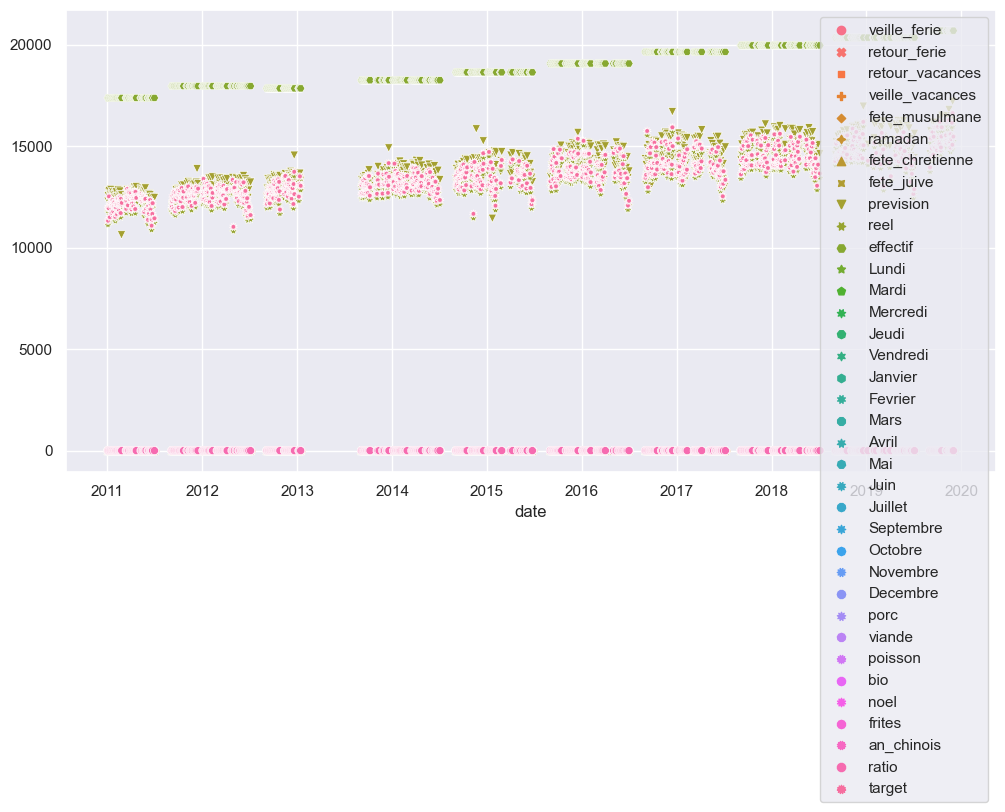

In [26]:
sns.scatterplot(data)

In [27]:
# Create rolling std deviation feature
data['reel_rolling_std'] = data['reel'].rolling(window=7).std()
data.head(10)

,annee_scolaire,veille_ferie,retour_ferie,retour_vacances,veille_vacances,fete_musulmane,ramadan,fete_chretienne,fete_juive,prevision,reel,effectif,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Septembre,Octobre,Novembre,Decembre,porc,viande,poisson,bio,noel,frites,an_chinois,ratio,target,reel_rolling_std
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,2010-2011,0,0,1,0,0,0,0,0,12289,11129,17373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.640592,11329,NaN
2011-01-04,2010-2011,0,0,0,0,0,0,0,0,12558,11808,17373,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.679675,12008,NaN
2011-01-06,2010-2011,0,0,0,0,0,0,1,0,12753,11741,17373,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0.675819,11941,NaN
2011-01-07,2010-2011,0,0,0,0,0,0,1,0,12812,12322,17373,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.709261,12522,NaN
2011-01-10,2010-2011,0,0,0,0,0,0,0,0,12309,11302,17373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.650550,11502,NaN
2011-01-11,2010-2011,0,0,0,0,0,0,0,0,12576,11909,17373,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0.685489,12109,NaN
2011-01-13,2010-2011,0,0,0,0,0,0,0,0,12628,12007,17373,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0.691130,12207,409.910095
2011-01-14,2010-2011,0,0,0,0,0,0,0,0,12865,11991,17373,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.690209,12191,311.536438
2011-01-17,2010-2011,0,0,0,0,0,0,0,0,12291,11508,17373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.662407,11708,340.542564


## 3. analyse pre-modeling

In [28]:
data["annee_scolaire"].unique()

array(['2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015',
       '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020'],
      dtype=object)

<Axes: xlabel='annee_scolaire'>

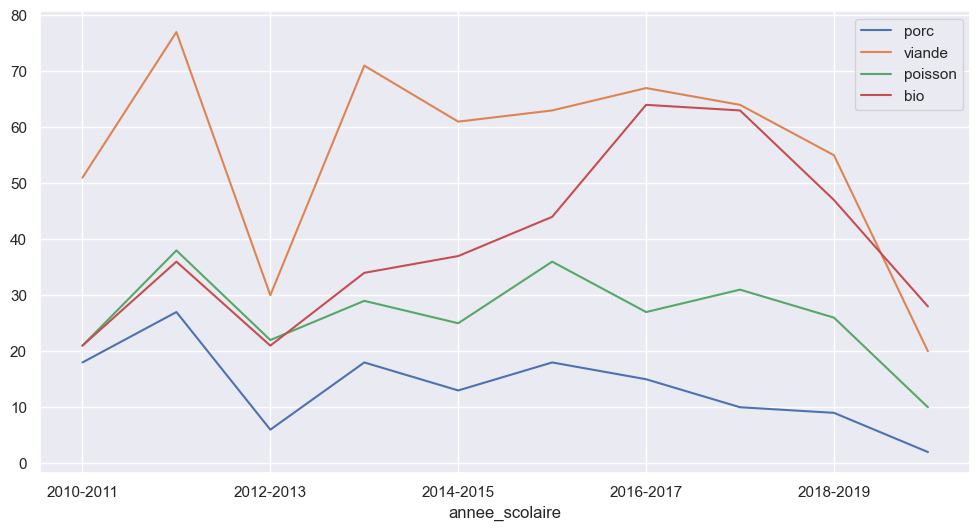

In [29]:

data.groupby("annee_scolaire")["porc","viande","poisson","bio"].sum().plot()

stable after 2013

<Axes: xlabel='date'>

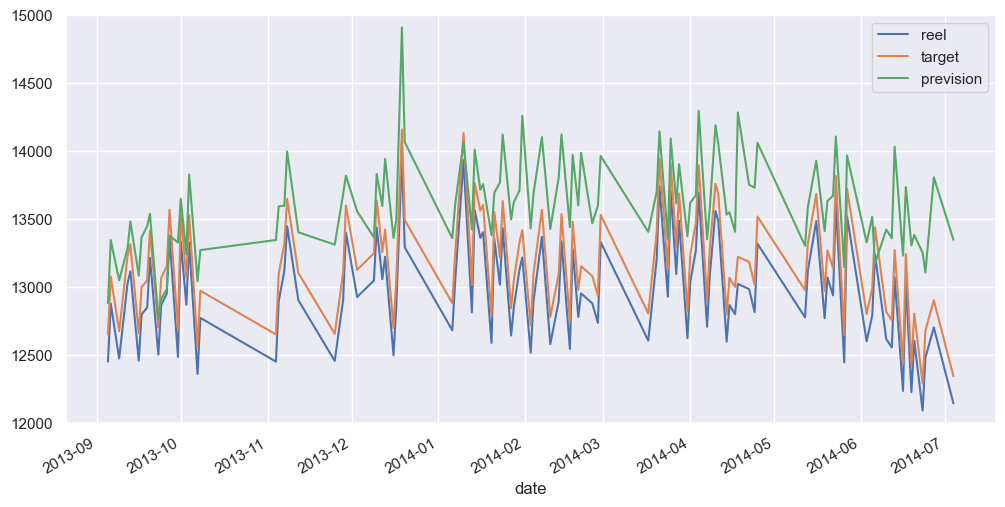

In [30]:
data[data["annee_scolaire"]=="2013-2014"][["reel","target","prevision"]].plot(ylim=(12000,15000))

<Axes: xlabel='date'>

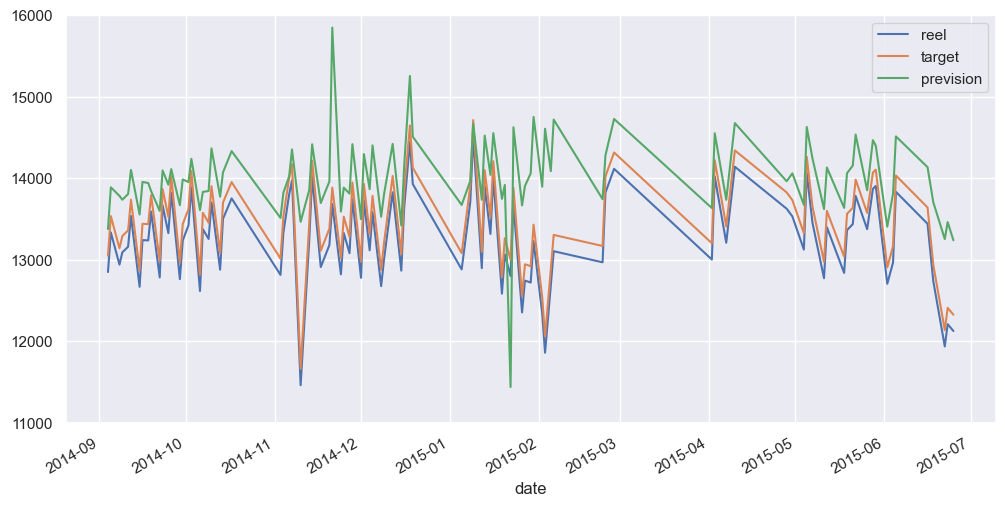

In [31]:
data[data["annee_scolaire"]=="2014-2015"][["reel","target","prevision"]].plot(ylim=(11000,16000))

In [32]:
data[(data["annee_scolaire"]=="2014-2015")&(data.reel<12000)]

,annee_scolaire,veille_ferie,retour_ferie,retour_vacances,veille_vacances,fete_musulmane,ramadan,fete_chretienne,fete_juive,prevision,reel,effectif,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Septembre,Octobre,Novembre,Decembre,porc,viande,poisson,bio,noel,frites,an_chinois,ratio,target,reel_rolling_std
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-11-10,2014-2015,1,0,0,0,0,0,0,0,13466,11464,18633,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.615253,11664,868.595939
2015-02-03,2014-2015,0,0,0,0,0,0,0,0,14607,11862,18633,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.636612,12062,604.602191
2015-06-22,2014-2015,0,0,0,0,0,1,0,0,13255,11939,18633,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.640745,12139,701.377420


2014-11-10 le pont. 2015-02-03 grippe. 05-13 le pont.

<Axes: xlabel='date'>

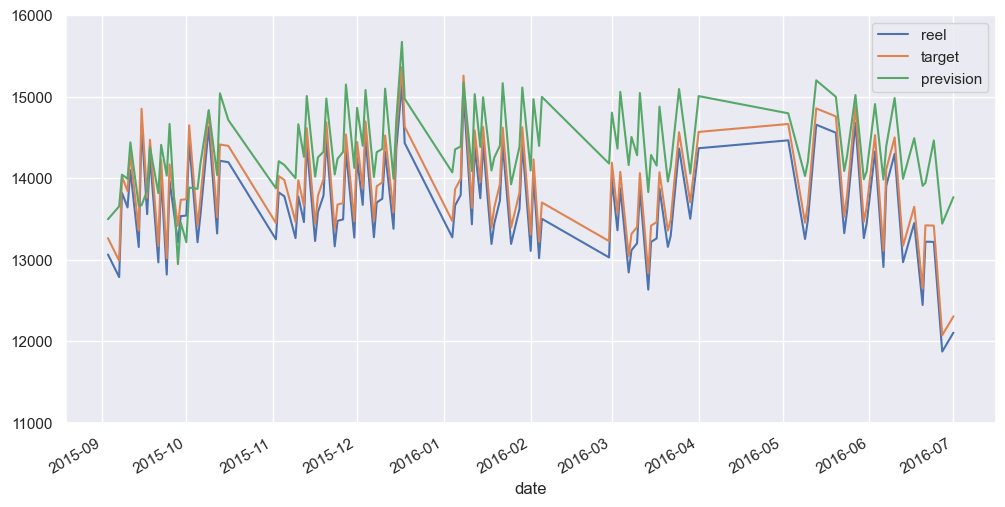

In [33]:
data[data["annee_scolaire"]=="2015-2016"][["reel","target","prevision"]].plot(ylim=(11000,16000))

In [34]:
data[(data["annee_scolaire"]=="2015-2016")&(data.reel<13000)]

,annee_scolaire,veille_ferie,retour_ferie,retour_vacances,veille_vacances,fete_musulmane,ramadan,fete_chretienne,fete_juive,prevision,reel,effectif,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Septembre,Octobre,Novembre,Decembre,porc,viande,poisson,bio,noel,frites,an_chinois,ratio,target,reel_rolling_std
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-09-07,2015-2016,0,0,0,0,0,0,0,0,13656,12789,19066,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.670775,12989,546.126010
2015-09-21,2015-2016,0,0,0,0,0,0,0,0,13818,12969,19066,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.680216,13169,607.118840
2015-09-24,2015-2016,0,0,0,0,0,0,0,0,14033,12820,19066,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0.672401,13020,698.689113
2016-03-07,2015-2016,0,0,0,0,0,0,0,0,14162,12846,19066,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.673765,13046,442.283738
2016-03-14,2015-2016,0,0,0,0,0,0,1,0,13831,12635,19066,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.662698,12835,472.673148
2016-06-06,2015-2016,0,0,0,0,1,1,0,0,13984,12912,19066,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0.677226,13112,627.092763
2016-06-13,2015-2016,0,0,0,0,0,1,0,0,13993,12971,19066,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.680321,13171,594.347381
2016-06-20,2015-2016,0,0,0,0,0,1,0,0,13907,12447,19066,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.652838,12647,733.132646
2016-06-27,2015-2016,0,0,0,0,0,1,0,0,13444,11876,19066,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.622889,12076,766.761091


2016-03-07 et 14 grippe. 2016-06-06 ramadan et porc. 13,20,27 pas de porc mais ils sont fatiguées. 01-07 vendredi pour le jour de prier.

2014-11-10 le pont.
2015-02-03 grippe.
2015-06-23 ramadan et porc.
2015-06-25 ramadon et viande veau.

<Axes: xlabel='date'>

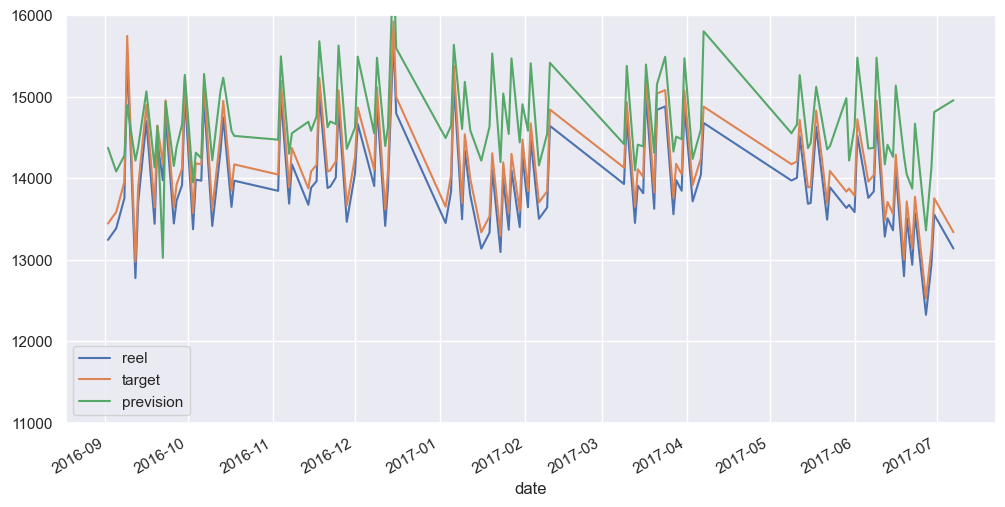

In [35]:
data[data["annee_scolaire"]=="2016-2017"][["reel","target","prevision"]].plot(ylim=(11000,16000))

In [36]:
data[data.ratio>0.75].head(20)

,annee_scolaire,veille_ferie,retour_ferie,retour_vacances,veille_vacances,fete_musulmane,ramadan,fete_chretienne,fete_juive,prevision,reel,effectif,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Septembre,Octobre,Novembre,Decembre,porc,viande,poisson,bio,noel,frites,an_chinois,ratio,target,reel_rolling_std
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-12-20,2012-2013,0,0,0,0,0,0,0,0,14550,13535,17842,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0.758603,13735,515.818582
2013-12-19,2013-2014,0,0,0,0,0,0,0,0,14908,13959,18243,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0.765170,14159,459.770750
2014-01-10,2013-2014,0,0,0,0,0,0,0,0,14066,13933,18243,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.763745,14133,580.410733
2014-03-21,2013-2014,0,0,0,0,0,0,0,0,14145,13741,18243,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.753220,13941,389.871102
2014-03-25,2013-2014,0,0,0,0,0,0,1,0,14092,13707,18243,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.751357,13907,448.069882
2014-04-04,2013-2014,0,0,0,0,0,0,0,0,14297,13696,18243,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0.750754,13896,391.575754
2014-11-14,2014-2015,0,0,0,0,0,0,0,0,14416,14015,18633,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0.752160,14215,893.972941
2014-12-18,2014-2015,0,0,0,0,0,0,0,0,15254,14447,18633,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0.775345,14647,621.504473
2015-01-09,2014-2015,0,0,0,0,0,0,0,0,14670,14513,18633,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0.778887,14713,662.585304


We can see poisson and bio with 75% students

In [37]:
dish_date_corr = data[["porc","viande", "poisson", "bio","frites",'Lundi', 'Mardi', 'Vendredi']].corr()
dish_date_corr

,porc,viande,poisson,bio,frites,Lundi,Mardi,Vendredi
porc,1.000000,0.317214,-0.249572,0.036563,0.007500,0.064863,0.065753,-0.240339
viande,0.317214,1.000000,-0.783098,-0.088085,0.113824,0.322268,0.089085,-0.741340
poisson,-0.249572,-0.783098,1.000000,-0.005618,-0.091423,-0.281539,-0.016136,0.579001
bio,0.036563,-0.088085,-0.005618,1.000000,-0.015032,-0.076941,-0.036927,0.075546
frites,0.007500,0.113824,-0.091423,-0.015032,1.000000,-0.079328,0.063567,-0.086963
Lundi,0.064863,0.322268,-0.281539,-0.076941,-0.079328,1.000000,-0.324232,-0.352017
Mardi,0.065753,0.089085,-0.016136,-0.036927,0.063567,-0.324232,1.000000,-0.344887
Vendredi,-0.240339,-0.741340,0.579001,0.075546,-0.086963,-0.352017,-0.344887,1.000000


<Axes: >

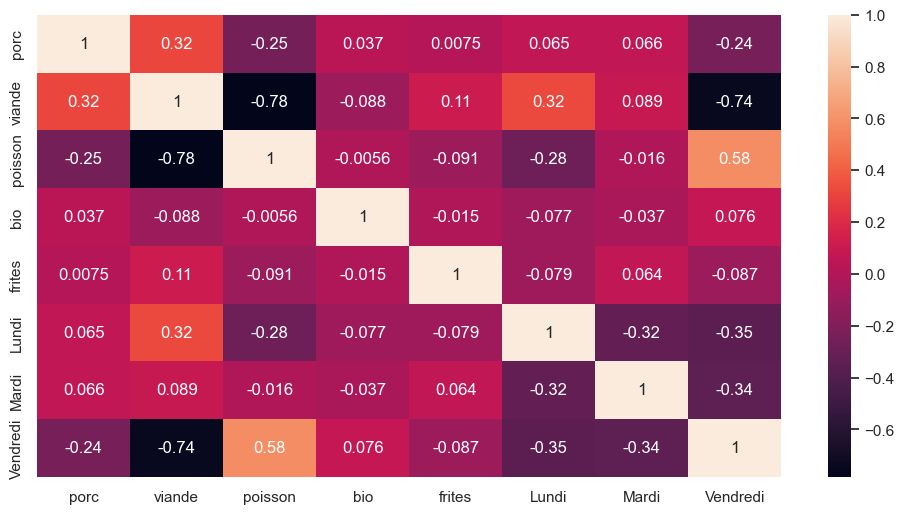

In [38]:
sns.heatmap(dish_date_corr, annot=True)

In [39]:
df_jourmois

,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Septembre,Octobre,Novembre,Decembre
date,,,,,,,,,,,,,,,,
2011-01-03,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2011-01-04,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2011-01-06,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2011-01-07,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2011-01-10,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-09,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2019-12-10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2019-12-13,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [40]:
# separation data to train data and test data
data_train = data[
    # (data["annee_scolaire"] == "2010-2011")|
    # (data["annee_scolaire"] == "2011-2012")|
    (data["annee_scolaire"] == "2012-2013")|
    (data["annee_scolaire"] == "2013-2014")|
    (data["annee_scolaire"] == "2014-2015")|
    (data["annee_scolaire"] == "2015-2016")|
    (data["annee_scolaire"] == "2016-2017")|
    (data["annee_scolaire"] == "2017-2018") 
]
data_test = data[
    (data["annee_scolaire"] == "2018-2019") |
    (data["annee_scolaire"] == "2019-2020") 
]

print(data_train.shape, data_test.shape)

(590, 38) (137, 38)


In [41]:
# data.drop(columns="annee_scolaire", inplace=True)
# data_train.drop(columns="annee_scolaire", inplace=True)
# data_test.drop(columns="annee_scolaire", inplace=True)

je peux potentiellement garder les variables "ramadan", "inc_gastro", "inc_varicelle", et les jours et les mois.

In [42]:
df_X2 = data_train[["porc","viande", "poisson", "bio","noel","frites","an_chinois"]]
df_y2 = data_train["reel"]

test_X2 = data_test[["porc","viande", "poisson", "bio","noel","frites","an_chinois"]]
test_y2 =data_test["reel"]

In [43]:
model = sm.OLS(df_y2, df_X2)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                   reel   R-squared (uncentered):                   0.903
Model:                            OLS   Adj. R-squared (uncentered):              0.902
Method:                 Least Squares   F-statistic:                              776.9
Date:                Wed, 19 Jul 2023   Prob (F-statistic):                   8.83e-291
Time:                        16:32:25   Log-Likelihood:                         -5762.2
No. Observations:                 590   AIC:                                  1.154e+04
Df Residuals:                     583   BIC:                                  1.157e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Regression

In [44]:
data_train.columns

Index(['annee_scolaire', 'veille_ferie', 'retour_ferie', 'retour_vacances',
       'veille_vacances', 'fete_musulmane', 'ramadan', 'fete_chretienne',
       'fete_juive', 'prevision', 'reel', 'effectif', 'Lundi', 'Mardi',
       'Mercredi', 'Jeudi', 'Vendredi', 'Janvier', 'Fevrier', 'Mars', 'Avril',
       'Mai', 'Juin', 'Juillet', 'Septembre', 'Octobre', 'Novembre',
       'Decembre', 'porc', 'viande', 'poisson', 'bio', 'noel', 'frites',
       'an_chinois', 'ratio', 'target', 'reel_rolling_std'],
      dtype='object')

In [45]:
feature_cols=[
    'veille_ferie', 
    # 'retour_ferie',  
    # 'retour_vacances',
    'veille_vacances', 
    # 'fete_musulmane',
    # 'ramadan',
    # 'fete_chretienne',
    # 'fete_juive',
    'effectif',
    'Lundi', 
    # 'Mardi', 
    # 'Jeudi', 
    'Vendredi',
    # 'Janvier',
    # 'Fevrier',
    # 'Mars', 
    # 'Avril', 
    # 'Mai',
    'Juin', 
    'Juillet',
    'Septembre',
    # 'Octobre',
    # 'Novembre', 
    # 'Decembre', 
    # 'porc', 
    'viande',
    'poisson', 
    # 'bio', 
    'noel',
    # 'frites',
    # 'an_chinois',
    'reel_rolling_std'
]

X_train = data_train[feature_cols]
y_train = data_train["reel"]


X_test = data_test[feature_cols]
y_test = data_test["reel"]


In [46]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# this for fliter the features

estimator = LinearRegression()

selector = RFE(estimator, n_features_to_select=15, step=3)
selector = selector.fit(X_train, y_train)

print("Num Features: %s" % (selector.n_features_))
print("Selected Features: %s" % (selector.support_))
print("Feature Ranking: %s" % (selector.ranking_))

feature_names = list(X_train.columns)

# features that you can keep
# selected_features = [feature for mask, feature in zip(selector.support_, feature_names) if mask]

# print("Selected features:")
# for feature in selected_features:
#     print(feature)

# features which are recommended to get rid of
unselected_features = [feature for mask, feature in zip(selector.support_, feature_names) if not mask]

print("---------------\n","You can turn it(s) off:")
for feature in unselected_features:
    print(feature)


Num Features: 12
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1]
---------------
 You can turn it(s) off:


In [47]:
model = sm.OLS(y_train, X_train)

In [48]:
results = model.fit()

In [49]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   reel   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          9.535e+04
Date:                Wed, 19 Jul 2023   Prob (F-statistic):                        0.00
Time:                        16:32:25   Log-Likelihood:                         -4211.6
No. Observations:                 590   AIC:                                      8447.
Df Residuals:                     578   BIC:                                      8500.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
veille_ferie      -235.8616    138.679     -1.701      0.090    -508.238      36.515
veille_vacances   -224.7063     81.284     -2.764      0.006    -384.355     -65.058
effectif             0.7203      0.004    192.363      0.000       0.713       0.728
Lundi             -424.2411     32.102    -13.216      0.000    -487.291    -361.191
Vendredi           279.4052     44.422      6.290      0.000     192.156     366.654
Juin              -542.4740     42.666    -12.714      0.000    -626.273    -458.675
Juillet          -1675.0059    157.091    -10.663      0.000   -1983.545   -1366.467
Septembre         -197.5748     36.511     -5.411      0.000    -269.285    -125.865
viande            -262.3950     54.653     -4.801      0.000    -369.738    -155.052
poisson            164.0209     45.683      3.590      0.000      74.296     253.746
noel              1160.3232    139.723      8.304      0.000     885.896    1434.751
reel_rolling_std     0.2026      0.092      2.197      0.028       0.021       0.384
==============================================================================
Omnibus:                      123.302   Durbin-Watson:                   1.241
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              567.356
Skew:                          -0.856   Prob(JB):                    6.31e-124
Kurtosis:                       7.489   Cond. No.                     2.36e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
from sklearn.linear_model import LinearRegression


In [51]:
LR = LinearRegression()

In [52]:
LR.fit(X_train, y_train)

LinearRegression()

In [53]:
print(f"train score: {LR.score(X_train, y_train)}")
print(f"test score: {LR.score(X_test, y_test)}")

train score: 0.8446912694257431
test score: 0.6079926707694021


In [94]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

LR = LinearRegression()
mse = make_scorer(mean_squared_error)

# Perform 10-fold cross validation
scores = cross_val_score(LR, X_train, y_train, cv=10, scoring=mse)

# Take the mean of the scores
mean_mse = np.mean(scores)
print('Mean MSE:', mean_mse)


Mean MSE: 104494.82031623885


In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data


,feature
0,veille_ferie
1,veille_vacances
2,effectif
3,Lundi
4,Vendredi
5,Juin
6,Juillet
7,Septembre
8,viande
9,poisson


In [56]:
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
vif_data

,feature,VIF
0,veille_ferie,1.014538
1,veille_vacances,1.115342
2,effectif,31.516416
3,Lundi,1.609142
4,Vendredi,3.310361
5,Juin,1.152368
6,Juillet,1.041451
7,Septembre,1.209538
8,viande,11.219120
9,poisson,3.743160


In [57]:
from sklearn.cross_decomposition import PLSRegression

In [58]:
pls = PLSRegression(n_components=11)

In [59]:
pls.fit(X_train, y_train)

PLSRegression(n_components=11)

In [60]:
print(f"train score: {pls.score(X_train, y_train)}")
print(f"test score: {pls.score(X_test, y_test)}")

train score: 0.8446912694257431
test score: 0.6079926700886648


In [100]:
# 10-fold cross validation
from sklearn.metrics import make_scorer

mse = make_scorer(mean_squared_error, greater_is_better=False)
scores = cross_val_score(pls, X_train, y_train, cv=10, scoring=mse)

# Take the mean of the scores
mean_mse = np.mean(scores)
print('Mean MSE:', mean_mse)

# Refit the model on the training data
pls.fit(X_train, y_train)

# R^2 scores
print(f"Train score: {pls.score(X_train, y_train)}")
print(f"Test score: {pls.score(X_test, y_test)}")


Mean MSE: -104494.82037275351
Train score: 0.8446912694257431
Test score: 0.6079926700886648


In [101]:
y_pred = pls.predict(X_test)

y_pred_merge = y_pred*(1+0.027)

df_pred = pd.DataFrame(y_pred_merge, columns=["prediction"])

df_reel_18_19 = data[(data["annee_scolaire"] == "2018-2019")|(data["annee_scolaire"] == "2019-2020")][["reel"]]

df_prev_18_19 = data[(data["annee_scolaire"] == "2018-2019")|(data["annee_scolaire"] == "2019-2020")][["prevision"]]


reel = df_reel_18_19.reset_index()
prev = df_prev_18_19.reset_index()

pred = df_pred
df_differences = pd.DataFrame({'reel': reel['reel'], 'prev': prev['prevision'], 'pred': pred['prediction']})
df_differences["dif_reel_prev"] = df_differences['prev'] - df_differences['reel']
df_differences["dif_reel_pred"] = df_differences['pred'] - df_differences['reel']
df_differences.round(2)

,reel,prev,pred,dif_reel_prev,dif_reel_pred
0,14070,14582,15220.83,512,1150.83
1,14261,14553,14784.41,292,523.41
2,14930,15206,15338.23,276,408.23
3,14391,14611,14797.03,220,406.03
4,14278,14820,14783.98,542,505.98
...,...,...,...,...,...
132,15143,15880,15063.05,737,-79.95
133,15954,15847,15252.83,-107,-701.17
134,14864,15832,15247.92,968,383.92
135,16423,17201,15996.24,778,-426.76


In [79]:
((df_differences["dif_reel_prev"].sum())-(df_differences["dif_reel_pred"].sum()))/(df_differences["dif_reel_prev"].sum())

0.5200438459459691

In [126]:
df_differences[df_differences.dif_reel_pred<-200]


,reel,prev,pred,dif_reel_prev,dif_reel_pred
88,14971,15431,14661.643260,460,-309.356740
122,15334,15731,15068.251658,397,-265.748342
133,15954,15847,15252.833401,-107,-701.166599
135,16423,17201,15996.244145,778,-426.755855


In [124]:
df_temp = df_reel_18_19.reset_index()
df_temp[df_temp.index.isin([88, 122, 133, 135])].set_index("date").index

DatetimeIndex(['2019-06-11', '2019-11-04', '2019-11-26', '2019-11-29'], dtype='datetime64[ns]', name='date', freq=None)

In [125]:
data[data.index.isin(['2019-06-11', '2019-11-04', '2019-11-26', '2019-11-29'])]

,annee_scolaire,veille_ferie,retour_ferie,retour_vacances,veille_vacances,fete_musulmane,ramadan,fete_chretienne,fete_juive,prevision,reel,effectif,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Septembre,Octobre,Novembre,Decembre,porc,viande,poisson,bio,noel,frites,an_chinois,ratio,target,reel_rolling_std
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-06-11,2018-2019,0,1,0,0,0,0,0,0,15431,14971,20344,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.735893,15171,619.421504
2019-11-04,2019-2020,0,0,1,0,0,0,0,0,15731,15334,20685,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.741310,15534,517.544017
2019-11-26,2019-2020,0,0,0,0,0,0,0,0,15847,15954,20685,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0.771284,16154,489.861010
2019-11-29,2019-2020,0,0,0,0,0,0,0,0,17201,16423,20685,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0.793957,16623,618.915642


# Extra -- I tested others models

In [81]:
from sklearn.linear_model import Lasso

In [82]:
alpha_value=0.01
lasso = Lasso(alpha = alpha_value)
lasso.fit(X_train, y_train)

Lasso(alpha=0.01)

In [83]:
print(f"train score (Lasso): {lasso.score(X_train, y_train)}")
print(f"test score (Lasso): {lasso.score(X_test, y_test)}")

train score (Lasso): 0.8446911816833957
test score (Lasso): 0.6079899938959289


In [84]:
from sklearn.linear_model import ElasticNet

In [85]:
alpha_value = 0.01
l1_ratio_value = 1
enm = ElasticNet(alpha=alpha_value, l1_ratio=l1_ratio_value)

In [86]:
enm.fit(X_train, y_train)

ElasticNet(alpha=0.01, l1_ratio=1)

In [87]:
print(f"train score (Lasso): {enm.score(X_train, y_train)}")
print(f"test score (Lasso): {enm.score(X_test, y_test)}")

train score (Lasso): 0.8446911816833957
test score (Lasso): 0.6079899938959289


In [88]:
import lightgbm as lgb

In [89]:
regressor = lgb.LGBMRegressor()
regressor.fit(X_train, y_train)

LGBMRegressor()

In [90]:
print(f"train score: {regressor.score(X_train, y_train)}")
print(f"test score : {regressor.score(X_test, y_test)}")

train score: 0.8936762904619153
test score : -0.04421370481804887


In [91]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=120, learning_rate=0.1)

gb.fit(X_train, y_train)

print("Training score: ", gb.score(X_train, y_train))
print("Testing score: ", gb.score(X_test, y_test))

Training score:  0.9221784007286259
Testing score:  0.14407968008115823


In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4]
}

gbm = GradientBoostingRegressor()

grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

print("Best score: ", grid_search.best_score_)


Best parameters:  {'learning_rate': 0.1, 'n_estimators': 100}
Best score:  0.39918061354303014


In [199]:
from sklearn.model_selection import cross_val_score



model = GradientBoostingRegressor()


scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

print("Cross-validated scores:", scores)
print("Mean cross-validated score:", scores.mean())

Cross-validated scores: [-0.15873614  0.49219168  0.46991901  0.6765594   0.31452202]
Mean cross-validated score: 0.35889119384908297
